In [101]:
import gzip
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import shutil
import json

# Inspect full image archive without extracting all files

In [2]:
zipf = zipfile.ZipFile('Fashion_Product_Images_Kaggle.zip') # not using high-res images to simplify data wrangling

In [5]:
len(filenames)

177778

In [10]:
filenames = zipf.namelist()
df = pd.DataFrame([x.split('/') for x in filenames[:]], columns=['root_path', 'path1', 'folder', 'filename'])
df['path'] = filenames

In [11]:
df = df.dropna()
df = df[df.filename != '']
df = df.reset_index()
print(len(df))
df.sample(n=10)

88887


,index,root_path,path1,folder,filename,path
76783,76785,fashion-dataset,fashion-dataset,styles,4933.json,fashion-dataset/fashion-dataset/styles/4933.json
78892,78894,fashion-dataset,fashion-dataset,styles,5193.json,fashion-dataset/fashion-dataset/styles/5193.json
37544,37545,fashion-dataset,fashion-dataset,images,56032.jpg,fashion-dataset/fashion-dataset/images/56032.jpg
64590,64592,fashion-dataset,fashion-dataset,styles,33954.json,fashion-dataset/fashion-dataset/styles/33954.json
54446,54448,fashion-dataset,fashion-dataset,styles,21545.json,fashion-dataset/fashion-dataset/styles/21545.json
7923,7924,fashion-dataset,fashion-dataset,images,19146.jpg,fashion-dataset/fashion-dataset/images/19146.jpg
54135,54137,fashion-dataset,fashion-dataset,styles,21160.json,fashion-dataset/fashion-dataset/styles/21160.json
21302,21303,fashion-dataset,fashion-dataset,images,35240.jpg,fashion-dataset/fashion-dataset/images/35240.jpg
53134,53136,fashion-dataset,fashion-dataset,styles,19946.json,fashion-dataset/fashion-dataset/styles/19946.json
75119,75121,fashion-dataset,fashion-dataset,styles,47143.json,fashion-dataset/fashion-dataset/styles/47143.json


In [14]:
np.unique(df.root_path)
np.unique(df.path1)
np.unique(df.folder)

array(['images', 'styles'], dtype=object)

In [15]:
osize = 0 
for item in zipf.infolist():
    osize += item.file_size
print('uncompressed size =',round(osize/1000000000,2),'GB')

uncompressed size = 31.42 GB


# Basic EDA

### Number of product types (each image file is a unique product)

In [17]:
# Number of unique products
len(df[df.folder=='images'])

44441

In [21]:
for x in filenames:
    if 'csv' in x:
        print(x)

fashion-dataset/fashion-dataset/images.csv
fashion-dataset/fashion-dataset/styles.csv
fashion-dataset/images.csv
fashion-dataset/styles.csv


In [29]:
styles = pd.read_csv('styles.csv', error_bad_lines=False)

/Users/blairjones/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping l

In [31]:
styles.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [34]:
np.unique(styles.articleType)

array(['Accessory Gift Set', 'Baby Dolls', 'Backpacks', 'Bangle',
       'Basketballs', 'Bath Robe', 'Beauty Accessory', 'Belts', 'Blazers',
       'Body Lotion', 'Body Wash and Scrub', 'Booties', 'Boxers', 'Bra',
       'Bracelet', 'Briefs', 'Camisoles', 'Capris', 'Caps',
       'Casual Shoes', 'Churidar', 'Clothing Set', 'Clutches', 'Compact',
       'Concealer', 'Cufflinks', 'Cushion Covers', 'Deodorant', 'Dresses',
       'Duffel Bag', 'Dupatta', 'Earrings', 'Eye Cream', 'Eyeshadow',
       'Face Moisturisers', 'Face Scrub and Exfoliator',
       'Face Serum and Gel', 'Face Wash and Cleanser', 'Flats',
       'Flip Flops', 'Footballs', 'Formal Shoes', 'Foundation and Primer',
       'Fragrance Gift Set', 'Free Gifts', 'Gloves', 'Hair Accessory',
       'Hair Colour', 'Handbags', 'Hat', 'Headband', 'Heels',
       'Highlighter and Blush', 'Innerwear Vests', 'Ipad', 'Jackets',
       'Jeans', 'Jeggings', 'Jewellery Set', 'Jumpsuit',
       'Kajal and Eyeliner', 'Key chain', 'Kurta Se

In [33]:
np.unique(styles.subCategory)

array(['Accessories', 'Apparel Set', 'Bags', 'Bath and Body',
       'Beauty Accessories', 'Belts', 'Bottomwear', 'Cufflinks', 'Dress',
       'Eyes', 'Eyewear', 'Flip Flops', 'Fragrance', 'Free Gifts',
       'Gloves', 'Hair', 'Headwear', 'Home Furnishing', 'Innerwear',
       'Jewellery', 'Lips', 'Loungewear and Nightwear', 'Makeup',
       'Mufflers', 'Nails', 'Perfumes', 'Sandal', 'Saree', 'Scarves',
       'Shoe Accessories', 'Shoes', 'Skin', 'Skin Care', 'Socks',
       'Sports Accessories', 'Sports Equipment', 'Stoles', 'Ties',
       'Topwear', 'Umbrellas', 'Vouchers', 'Wallets', 'Watches',
       'Water Bottle', 'Wristbands'], dtype=object)

In [36]:
clothing = styles[styles.subCategory.apply(lambda x: x in ['Bottomwear','Dress','Topwear','Apparel Set'])]

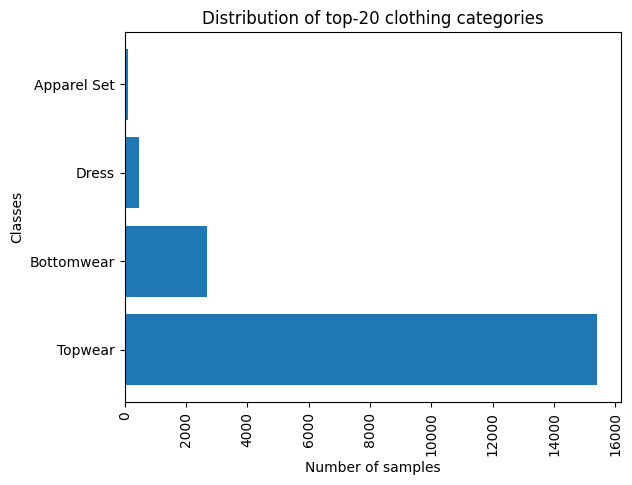

In [44]:
histdata = clothing.groupby(['subCategory']).count()
histdata = histdata.sort_values(by='id', ascending=False)

data = histdata['id'][:20]
plt.barh(data.index, data.values)
plt.title('Distribution of top-20 clothing categories')
plt.xticks(rotation = 90)
plt.ylabel('Classes')
plt.xlabel('Number of samples')
plt.show()

In [45]:
clothing = styles[styles.subCategory.apply(lambda x: x in ['Bottomwear','Topwear'])]

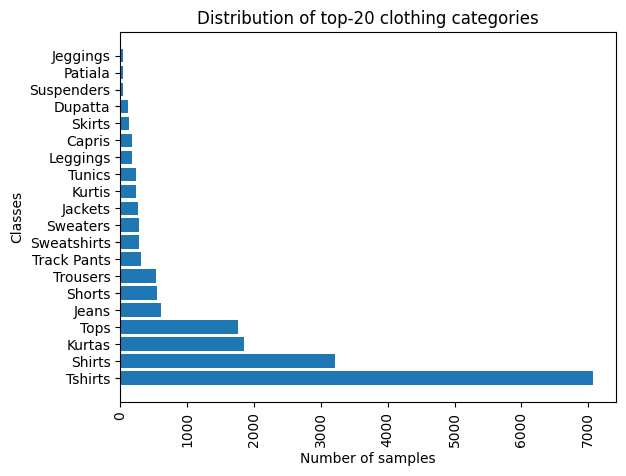

In [46]:
histdata = clothing.groupby(['articleType']).count()
histdata = histdata.sort_values(by='id', ascending=False)

data = histdata['id'][:20]
plt.barh(data.index, data.values)
plt.title('Distribution of top-20 clothing categories')
plt.xticks(rotation = 90)
plt.ylabel('Classes')
plt.xlabel('Number of samples')
plt.show()

### Inspect a few sample images and corresponding bounding boxes

In [70]:
toplot = clothing[clothing.articleType=='Shirts'][:10]

In [91]:
plotlist = df[df.filename.apply(lambda x: int(x.split('.')[0]) in toplot.id.values)]

In [92]:
plotlist

,index,root_path,path1,folder,filename,path
1974,1975,fashion-dataset,fashion-dataset,images,12369.jpg,fashion-dataset/fashion-dataset/images/12369.jpg
5090,5091,fashion-dataset,fashion-dataset,images,15970.jpg,fashion-dataset/fashion-dataset/images/15970.jpg
5102,5103,fashion-dataset,fashion-dataset,images,15984.jpg,fashion-dataset/fashion-dataset/images/15984.jpg
14520,14521,fashion-dataset,fashion-dataset,images,26960.jpg,fashion-dataset/fashion-dataset/images/26960.jpg
17653,17654,fashion-dataset,fashion-dataset,images,30805.jpg,fashion-dataset/fashion-dataset/images/30805.jpg
23196,23197,fashion-dataset,fashion-dataset,images,37812.jpg,fashion-dataset/fashion-dataset/images/37812.jpg
32372,32373,fashion-dataset,fashion-dataset,images,4943.jpg,fashion-dataset/fashion-dataset/images/4943.jpg
38229,38230,fashion-dataset,fashion-dataset,images,56825.jpg,fashion-dataset/fashion-dataset/images/56825.jpg
43974,43975,fashion-dataset,fashion-dataset,images,9452.jpg,fashion-dataset/fashion-dataset/images/9452.jpg
44166,44167,fashion-dataset,fashion-dataset,images,9660.jpg,fashion-dataset/fashion-dataset/images/9660.jpg


In [95]:
# extract sample images from archive
img_b = zipf.extractall(members=plotlist.path.values, path='temp/')

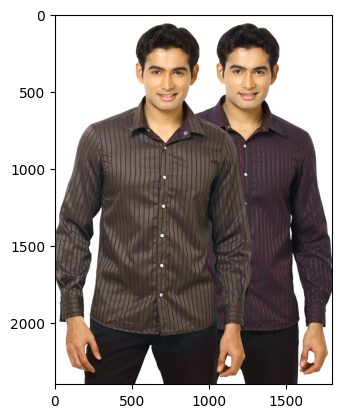

In [99]:
img = cv2.imread('temp/'+plotlist.iloc[9].path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()